# **ЛР №6**: Обучение нейронной сети PointNet++ для семантической сегментации облака точек

## **Ход работы**

## 1: Установка библиотек

Для обучения использовались Python 3.11.9 и GeForce RTX 5050 GPU, потому конкретная версия CUDA для повторения обучения может отличаться.

In [ ]:
%python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
%python -m pip install numpy scikit-learn open3d tqdm tensorboard matplotlib

## 2: Импорт библиотек и базовые настройки

In [ ]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix
import open3d as o3d
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Параметры
DATA_DIR = "Stanford3dDataset_v1.2"
NUM_CLASSES = 13
LEARNING_RATE = 0.001
BATCH_SIZE = 8
NUM_EPOCHS = 100
SCHEDULER_STEP_SIZE = 20
SCHEDULER_GAMMA = 0.5

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda
CUDA Device Name: NVIDIA GeForce RTX 5050 Laptop GPU
CUDA Version: 12.8


## 3: Определение классов и цветов для визуализации

In [ ]:
CLASS_LABELS = [
    "ceiling", "floor", "wall", "beam", "column", "window", "door",
    "table", "chair", "sofa", "bookcase", "board", "clutter"
]
CLASS_COLOR_MAP = {
    "ceiling": [0, 255, 0],      # зеленый
    "floor": [0, 0, 255],        # синий
    "wall": [0, 255, 255],       # голубой
    "beam": [255, 255, 0],       # желтый
    "column": [255, 0, 255],     # фиолетовый
    "window": [100, 100, 255],   # светло-фиолетовый
    "door": [200, 200, 100],     # светло-коричневый
    "table": [170, 120, 200],    # лавандовый
    "chair": [255, 0, 0],        # красный
    "sofa": [200, 100, 100],     # темно-розовый
    "bookcase": [20, 255, 150],  # мятный
    "board": [200, 200, 200],    # серый
    "clutter": [50, 50, 50]      # темно-серый
}

COLOR_PALETTE = np.array([CLASS_COLOR_MAP[label] for label in CLASS_LABELS])
print("Class labels:", CLASS_LABELS)
print("Number of classes:", NUM_CLASSES)

Class labels: ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase', 'board', 'clutter']
Number of classes: 13


## 4: Загрузка S3DIS

In [ ]:
def load_s3dis_area_annotations(data_dir, area_name, class_labels_map):
    """
    Загружает точки и метки из S3DIS, используя папку Annotations для разметки.
    Каждый файл в Annotations содержит точки (x, y, z, r, g, b) для одного класса.
    Использует scipy.spatial.cKDTree для эффективного сопоставления точек.

    Args:
        data_dir (str): Путь к корню датасета (Stanford3dDataset_v1.2).
        area_name (str): Имя области (e.g., "Area_1").
        class_labels_map (dict): Словарь {'имя_класса': индекс_класса}.

    Returns:
        tuple: (points_xyz_rgb, labels) - массивы numpy точек и меток.
               points_xyz_rgb: shape (N, 6) -> [x, y, z, r, g, b]
               labels: shape (N,) -> int (0-12)
    """
    try:
        from scipy.spatial import cKDTree
    except ImportError:
        raise ImportError("pip install scipy")

    area_path = os.path.join(data_dir, area_name)
    if not os.path.exists(area_path):
        raise ValueError(f"Area path does not exist: {area_path}")

    all_points = []
    all_labels = []

    room_dirs = [d for d in os.listdir(area_path) if os.path.isdir(os.path.join(area_path, d))]
    
    for room_name in tqdm(room_dirs, desc=f"Loading {area_name}"):
        room_file_path = os.path.join(area_path, room_name, f"{room_name}.txt")
        annotations_dir = os.path.join(area_path, room_name, "Annotations")
        
        if not os.path.exists(room_file_path):
            print(f"Warning: Main .txt file {room_file_path} not found, skipping room {room_name}.")
            continue
            
        if not os.path.exists(annotations_dir):
            print(f"Warning: Annotations directory {annotations_dir} not found, skipping room {room_name}.")
            continue

        try:
            room_points_full = np.loadtxt(room_file_path)
            if room_points_full.ndim == 1 or len(room_points_full) == 0:
                 print(f"Warning: Room file {room_file_path} is empty or malformed, skipping.")
                 continue
        except UnicodeDecodeError as e:
            print(f"Unicode error reading {room_file_path}: {e}. Skipping room {room_name}.")
            continue
        except ValueError as e:
            print(f"ValueError reading main room file {room_file_path}: {e}. Skipping room {room_name}.")
            continue
        except Exception as e:
            print(f"Unexpected error reading main room file {room_file_path}: {e}. Skipping room {room_name}.")
            continue

        room_labels_full = np.full((len(room_points_full),), -1, dtype=np.int32)

        room_tree = cKDTree(room_points_full[:, :3])

        annotation_files = [f for f in os.listdir(annotations_dir) if f.endswith('.txt')]
        found_any_match = False

        for ann_file in annotation_files:
            ann_file_path = os.path.join(annotations_dir, ann_file)
            class_name_from_file = ann_file.split('.')[0]

            base_class_name = class_name_from_file.split('_')[0]

            if base_class_name not in class_labels_map:
                continue

            class_label_idx = class_labels_map[base_class_name]

            try:
                ann_points = np.loadtxt(ann_file_path)
                if ann_points.ndim == 1:
                     if len(ann_points) >= 6:
                         ann_points = ann_points.reshape(1, -1)
                     else:
                         print(f"Warning: Annotation file {ann_file_path} has less than 6 coordinates in single row, skipping.")
                         continue
                ann_xyz = ann_points[:, :3]
                distances, indices = room_tree.query(ann_xyz, distance_upper_bound=1e-6)

                valid_matches = distances < np.inf
                matched_room_indices = indices[valid_matches]

                if len(matched_room_indices) > 0:
                    room_labels_full[matched_room_indices] = class_label_idx
                    found_any_match = True
                else:
                     print(f"Warning: No matches found (within tolerance) for {ann_file} in {room_name}.")

            except Exception as e:
                print(f"Error reading annotation file {ann_file_path}: {e}. Skipping annotation {ann_file} in room {room_name}.")
                continue

        valid_mask = room_labels_full != -1
        room_valid_points = room_points_full[valid_mask]
        room_valid_labels = room_labels_full[valid_mask]

        if len(room_valid_labels) > 0:
            all_points.append(room_valid_points)
            all_labels.append(room_valid_labels)
        elif found_any_match:
             print(f"Info: Room {room_name} had matches during processing but no final valid points after applying all annotations.")
        else:
            print(f"Warning: Room {room_name} has no labeled points after processing annotations.")

    if not all_points:
        raise ValueError(f"No valid rooms with labeled points found in {area_path}")

    points_xyz_rgb = np.concatenate(all_points, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    
    print(f"Loaded {len(points_xyz_rgb)} labeled points from {area_name}")
    return points_xyz_rgb, labels


CLASS_NAME_TO_IDX = {name: idx for idx, name in enumerate(CLASS_LABELS)}
print("CLASS_NAME_TO_IDX map:", CLASS_NAME_TO_IDX)

try:
    import scipy
    print(f"Scipy version: {scipy.__version__}")
except ImportError:
    print("Scipy is not installed. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy
    print(f"Scipy installed and loaded, version: {scipy.__version__}")


try:
    points_train_val, labels_train_val = load_s3dis_area_annotations(DATA_DIR, "Area_1", CLASS_NAME_TO_IDX)
    print(f"Successfully loaded training/validation data. Shape: {points_train_val.shape}, Labels shape: {labels_train_val.shape}")
    unique_labels, counts = np.unique(labels_train_val, return_counts=True)
    print(f"Unique labels found: {unique_labels}")
    print(f"Label counts: {counts}")
except ValueError as e:
    print(e)
    print("Could not load Area_1 or any other area with the required format and labels.")
except ImportError as ie:
    print(ie)

CLASS_NAME_TO_IDX map: {'ceiling': 0, 'floor': 1, 'wall': 2, 'beam': 3, 'column': 4, 'window': 5, 'door': 6, 'table': 7, 'chair': 8, 'sofa': 9, 'bookcase': 10, 'board': 11, 'clutter': 12}
Scipy version: 1.16.3


Loading Area_1:  61%|██████▏   | 27/44 [00:24<00:10,  1.55it/s]

ValueError reading main room file Stanford3dDataset_v1.2/Area_1/WC_1/WC_1.txt: could not convert string '56.00\x10000' to float64 at row 429612, column 6.. Skipping room WC_1.


Loading Area_1: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Loaded 42585226 labeled points from Area_1
Successfully loaded training/validation data. Shape: (42585226, 6), Labels shape: (42585226,)
Unique labels found: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label counts: [ 8082027  6234004 10877613  2116355  1291778  1471011  2198017  1612696
  1114423   168977  1765251   796492  4856582]


## 5: Класс Dataset для PyTorch

In [ ]:
class S3DISBlockDataset(Dataset):
    def __init__(self, points, labels, block_size=1.0, sample_rate=1.0, num_points_per_block=4096):
        """
        Dataset для блоков точек из S3DIS.

        Args:
            points (np.ndarray): Массив точек формы (N, 6) [x, y, z, r, g, b].
            labels (np.ndarray): Массив меток формы (N,).
            block_size (float): Размер блока (куба) для выборки.
            sample_rate (float): Доля блоков для выборки (для ускорения).
            num_points_per_block (int): Количество точек для сэмплирования из блока.
        """
        if len(points) != len(labels):
            raise ValueError(f"Mismatch between number of points ({len(points)}) and labels ({len(labels)}).")
            
        self.block_size = block_size
        self.num_points_per_block = num_points_per_block
        
        if points[:, 3:].max() > 1:
             points_normalized = points.copy()
             points_normalized[:, 3:] /= 255.0
        else:
            points_normalized = points

        coord_min = np.min(points_normalized[:, :3], axis=0)
        coord_max = np.max(points_normalized[:, :3], axis=0)
        grid_x = int(np.ceil((coord_max[0] - coord_min[0]) / block_size))
        grid_y = int(np.ceil((coord_max[1] - coord_min[1]) / block_size))

        self.blocks = []
        self.labels = []

        for index_y in tqdm(range(grid_y), desc="Creating blocks"):
            for index_x in range(grid_x):
                 s_x = coord_min[0] + block_size * index_x
                 e_x = min(coord_min[0] + block_size * (index_x + 1), coord_max[0])
                 s_y = coord_min[1] + block_size * index_y
                 e_y = min(coord_min[1] + block_size * (index_y + 1), coord_max[1])

                 mask = (points_normalized[:, 0] >= s_x) & (points_normalized[:, 0] <= e_x) & \
                        (points_normalized[:, 1] >= s_y) & (points_normalized[:, 1] <= e_y)
                 block_points = points_normalized[mask]
                 block_labels = labels[mask]

                 if block_labels.size == 0:
                     continue

                 if block_labels.min() < 0 or block_labels.max() >= NUM_CLASSES:
                    print(f"Warning: Found labels out of range [0, {NUM_CLASSES-1}] in block. Min: {block_labels.min()}, Max: {block_labels.max()}. Skipping block.")
                    continue

                 block_center = np.array([(s_x + e_x) / 2.0, (s_y + e_y) / 2.0, coord_min[2]])
                 centered_points = block_points.copy()
                 centered_points[:, :3] -= block_center

                 if len(centered_points) >= num_points_per_block:
                     choice = np.random.choice(len(centered_points), num_points_per_block, replace=False)
                 else:
                     choice = np.random.choice(len(centered_points), num_points_per_block, replace=True)
                 
                 sampled_points = centered_points[choice]
                 sampled_labels = block_labels[choice]

                 self.blocks.append(sampled_points)
                 self.labels.append(sampled_labels)

        if sample_rate < 1.0:
            num_blocks_to_keep = int(len(self.blocks) * sample_rate)
            if num_blocks_to_keep > 0:
                indices_to_keep = np.random.choice(len(self.blocks), num_blocks_to_keep, replace=False)
                self.blocks = [self.blocks[i] for i in indices_to_keep]
                self.labels = [self.labels[i] for i in indices_to_keep]
            else:
                print(f"Warning: sample_rate {sample_rate} resulted in 0 blocks to keep.")

        print(f"Created {len(self.blocks)} blocks.")

    def __len__(self):
        return len(self.blocks)

    def __getitem__(self, idx):
        points = self.blocks[idx]
        labels = self.labels[idx]

        return torch.from_numpy(points).float(), torch.from_numpy(labels).long()

print("S3DISBlockDataset class defined.")

S3DISBlockDataset class defined.


In [ ]:
if 'points_train_val' in locals() and 'labels_train_val' in locals():
    try:
        SAMPLE_RATE = 0.1
        dataset = S3DISBlockDataset(points_train_val, labels_train_val, block_size=1.0, sample_rate=SAMPLE_RATE, num_points_per_block=4096)
        print(f"Dataset size: {len(dataset)} blocks")
    except ValueError as e:
        print(f"Error creating dataset: {e}")
else:
    print("Data loading failed previously. Cannot create dataset.")

Creating blocks: 100%|██████████| 49/49 [08:54<00:00, 10.92s/it]

Created 104 blocks.
Dataset size: 104 blocks


## 6: Разделение на Train и Validation

In [ ]:
if 'dataset' in locals():
    from torch.utils.data import random_split

    total_size = len(dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f"Train dataset size: {len(train_dataset)} blocks")
    print(f"Validation dataset size: {len(val_dataset)} blocks")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    print("DataLoaders created.")
else:
    print("Dataset not created. Cannot create DataLoaders.")

Train dataset size: 84 blocks
Validation dataset size: 20 blocks
DataLoaders created.


## 7: Аугментации

In [ ]:
def augment_point_cloud(points, labels, jitter_sigma=0.01, jitter_clip=0.05, shift_range=0.1):
    """
    Применяет аугментации к облаку точек (x, y, z, r, g, b).

    Args:
        points (torch.Tensor): Точки формы (N, 6) [x, y, z, r, g, b].
        labels (torch.Tensor): Метки формы (N,).
        jitter_sigma (float): Стандартное отклонение для шума.
        jitter_clip (float): Максимальное отклонение для шума.
        shift_range (float): Диапазон сдвига для x, y, z.

    Returns:
        tuple: (augmented_points, labels)
    """
    augmented_points = points.clone()

    # 1. Сдвиг (Shift) координат
    shift = torch.randn(3) * shift_range
    augmented_points[:, :3] += shift

    # 2. Шум (Jitter) к координатам
    jitter = torch.randn_like(augmented_points[:, :3]) * jitter_sigma
    jitter = torch.clamp(jitter, min=-jitter_clip, max=jitter_clip)
    augmented_points[:, :3] += jitter

    return augmented_points, labels

if 'train_dataset' in locals():
    original_points, original_labels = train_dataset[0]
    print(f"Original points shape: {original_points.shape}, min/max: {original_points[:, :3].min():.3f}/{original_points[:, :3].max():.3f}")
    aug_points, aug_labels = augment_point_cloud(original_points, original_labels)
    print(f"After augmentation - shape: {aug_points.shape}, min/max: {aug_points[:, :3].min():.3f}/{aug_points[:, :3].max():.3f}")
    print(f"Labels unchanged: {torch.equal(original_labels, aug_labels)}")
else:
    print("Train dataset not available to test augmentations.")

Original points shape: torch.Size([4096, 6]), min/max: -0.500/3.469
After augmentation - shape: torch.Size([4096, 6]), min/max: -0.513/3.568
Labels unchanged: True


## 8: Обновление PyTorch Dataset для применения аугментаций

In [ ]:
class S3DISBlockDatasetWithAugmentation(S3DISBlockDataset):
    def __init__(self, points, labels, block_size=1.0, sample_rate=1.0, num_points_per_block=4096,
                 apply_augmentations=False, aug_jitter_sigma=0.01, aug_jitter_clip=0.05, aug_shift_range=0.1):
        super().__init__(points, labels, block_size, sample_rate, num_points_per_block)
        self.apply_augmentations = apply_augmentations
        self.aug_jitter_sigma = aug_jitter_sigma
        self.aug_jitter_clip = aug_jitter_clip
        self.aug_shift_range = aug_shift_range

    def __getitem__(self, idx):
        points, labels = super().__getitem__(idx)
        
        if self.apply_augmentations:
            points, labels = augment_point_cloud(
                points, labels,
                jitter_sigma=self.aug_jitter_sigma,
                jitter_clip=self.aug_jitter_clip,
                shift_range=self.aug_shift_range
            )
        
        return points, labels

SAMPLE_RATE_FINAL = 0.1
train_dataset_aug = S3DISBlockDatasetWithAugmentation(
    points_train_val, labels_train_val,
    block_size=1.0, sample_rate=SAMPLE_RATE_FINAL, num_points_per_block=4096,
    apply_augmentations=True,
    aug_jitter_sigma=0.01, aug_jitter_clip=0.05, aug_shift_range=0.1
)
val_dataset_no_aug = S3DISBlockDatasetWithAugmentation(
    points_train_val, labels_train_val,
    block_size=1.0, sample_rate=SAMPLE_RATE_FINAL, num_points_per_block=4096,
    apply_augmentations=False
)

print(f"Train dataset (with aug) size: {len(train_dataset_aug)} blocks")
print(f"Validation dataset (no aug) size: {len(val_dataset_no_aug)} blocks")

BATCH_SIZE_FINAL = BATCH_SIZE
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE_FINAL, shuffle=True, num_workers=2)
val_loader_no_aug = DataLoader(val_dataset_no_aug, batch_size=BATCH_SIZE_FINAL, shuffle=False, num_workers=2)
print("DataLoaders with augmentations created.")

Creating blocks: 100%|██████████| 49/49 [09:05<00:00, 11.12s/it]


Created 104 blocks.


Creating blocks: 100%|██████████| 49/49 [09:09<00:00, 11.21s/it]

Created 104 blocks.
Train dataset (with aug) size: 104 blocks
Validation dataset (no aug) size: 104 blocks
DataLoaders with augmentations created.


## 9: Архитектура PointNet++

In [ ]:
import torch.nn.functional as F

print("torch.nn.functional imported as F.")
def square_distance(src, dst):
    """
    Вычисляет квадрат евклидова расстояния между двумя наборами точек.
    src: shape (B, N, C)
    dst: shape (B, M, C)
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1)) # (B, N, M)
    dist += torch.sum(src ** 2, dim=-1).view(B, N, 1) # (B, N, 1)
    dist += torch.sum(dst ** 2, dim=-1).view(B, 1, M) # (B, 1, M)
    return dist


def index_points(points, idx):
    """
    Индексирует точки по индексам.
    points: shape (B, N, C)
    idx: shape (B, S) or (B, S, K)
    out: shape (B, S, C) or (B, S, K, C)
    """
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long, device=points.device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=device)
    batch_indices = torch.arange(B, dtype=torch.long, device=device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, C) # (B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1) # (B, N)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1] # (B,)
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Находит соседей в шаре заданного радиуса.
    radius: float
    nsample: int
    new_xyz: shape (B, S, 3) - центры шаров
    xyz: shape (B, N, 3) - все точки
    group_idx: shape (B, S, nsample)
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long, device=device).view(1, 1, N).repeat([B, S, 1]) # (B, S, N)
    sqrdists = square_distance(new_xyz, xyz) # (B, S, N)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample] # (B, S, nsample)
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample]) # (B, S, nsample)
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        xyz: shape (B, N, 3)
        points: shape (B, C, N) или None
        new_xyz: shape (B, S, 3)
        new_points: shape (B, C', S)
        """
        B, N, C_xyz = xyz.shape
        S = self.npoint
        if self.npoint is not None:
            fps_idx = farthest_point_sample(xyz, self.npoint) # (B, npoint)
            new_xyz = index_points(xyz, fps_idx) # (B, S, 3)
        else:
            new_xyz = xyz.mean(dim=1, keepdim=True) # (B, 1, 3)
            S = 1

        if self.group_all:
            idx = torch.arange(N, dtype=torch.long, device=xyz.device).view(1, 1, N).repeat(B, S, 1) # (B, S, N)
        else:
            idx = query_ball_point(self.radius, self.nsample, xyz, new_xyz) # (B, S, nsample)
        grouped_xyz = index_points(xyz, idx) # (B, S, nsample, 3)
        grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C_xyz) # (B, S, nsample, 3)

        if points is not None:
            grouped_points = index_points(points.transpose(1, 2), idx) # (B, S, nsample, C)
            new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # (B, S, nsample, 3+C)
        else:
            new_points = grouped_xyz_norm # (B, S, nsample, 3)

        new_points = new_points.permute(0, 3, 2, 1) # (B, C, nsample, S)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points))) # (B, C_out, nsample, S)

        new_points = torch.max(new_points, 2)[0] # (B, C_out, S)
        new_xyz = new_xyz.permute(0, 2, 1) # (B, 3, S)
        return new_xyz, new_points


class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        xyz1: shape (B, N, 3) - точки более высокого разрешения
        xyz2: shape (B, S, 3) - точки более низкого разрешения (куда интерполировать)
        points1: shape (B, C1, N) - фичи более высокого разрешения (или None)
        points2: shape (B, C2, S) - фичи более низкого разрешения
        out: shape (B, C_out, N)
        """
        B, N, C_xyz1 = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, 1, N) # (B, C2, N)
        else:
            dists = square_distance(xyz1, xyz2) # (B, N, S)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3] # (B, N, 3)
            dists_recip = 1.0 / (dists + 1e-8) # (B, N, 3)
            norm = torch.sum(dists_recip, dim=2, keepdim=True) # (B, N, 1)
            weight = dists_recip / norm # (B, N, 3)
            interpolated_points = torch.sum(index_points(points2.transpose(1, 2), idx) * weight.view(B, N, 3, 1), dim=2) # (B, N, C2)
            interpolated_points = interpolated_points.permute(0, 2, 1) # (B, C2, N)

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=1) # (B, C1+C2, N)
        else:
            new_points = interpolated_points # (B, C2, N)

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points


class PointNet2SSGSeg(nn.Module):
    def __init__(self, num_classes, input_dims=6):
        super(PointNet2SSGSeg, self).__init__()
        self.sa1 = PointNetSetAbstraction(1024, 0.1, 32, input_dims, [32, 32, 64], False)
        self.sa2 = PointNetSetAbstraction(256, 0.2, 32, 64 + 3, [64, 64, 128], False)
        self.sa3 = PointNetSetAbstraction(64, 0.4, 32, 128 + 3, [128, 128, 256], False)
        self.sa4 = PointNetSetAbstraction(None, None, None, 256 + 3, [256, 256, 512], True)

        self.fp4 = PointNetFeaturePropagation(768, [256, 256])
        self.fp3 = PointNetFeaturePropagation(384, [256, 256])
        self.fp2 = PointNetFeaturePropagation(320, [256, 128])
        self.fp1 = PointNetFeaturePropagation(131, [128, 128, 128])

        self.conv1 = nn.Conv1d(128, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, num_classes, 1)

    def forward(self, xyz):
        # xyz: (B, N, 6) -> (B, N, 3) coords, (B, N, 3) features (r, g, b)
        B, N, _ = xyz.shape
        l0_xyz = xyz[:, :, :3] # (B, N, 3)
        l0_points = xyz[:, :, 3:] # (B, N, 3)

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points.permute(0, 2, 1)) # (B, 3, N) -> (B, 3, 1024)
        l2_xyz, l2_points = self.sa2(l1_xyz.permute(0, 2, 1), l1_points) # (B, 3, 1024) -> (B, 3, 256)
        l3_xyz, l3_points = self.sa3(l2_xyz.permute(0, 2, 1), l2_points) # (B, 3, 256) -> (B, 3, 64)
        l4_xyz, l4_points = self.sa4(l3_xyz.permute(0, 2, 1), l3_points) # (B, 3, 64) -> (B, 3, 1) [global]
        l3_points = self.fp4(l3_xyz.permute(0, 2, 1), l4_xyz.permute(0, 2, 1), l3_points, l4_points) # (B, 256+256, 64)
        l2_points = self.fp3(l2_xyz.permute(0, 2, 1), l3_xyz.permute(0, 2, 1), l2_points, l3_points) # (B, 128+256, 256)
        l1_points = self.fp2(l1_xyz.permute(0, 2, 1), l2_xyz.permute(0, 2, 1), l1_points, l2_points) # (B, 64+256, 1024)
        # fp1: xyz1=l0_xyz(B,N,3), xyz2=l1_xyz(B,3,1024), points1=l0_points.permute(0,2,1) (B,3,N), points2=l1_points (B,128,1024)
        # Интерполяция l1_points (B,128,1024) -> (B,128,N)
        # cat( (B,3,N), (B,128,N) ) -> (B, 131, N)
        l0_points = self.fp1(l0_xyz, l1_xyz.permute(0, 2, 1), l0_points.permute(0, 2, 1), l1_points) # (B, 131, N) -> (B, 128, N)

        x = F.relu(self.bn1(self.conv1(l0_points))) # (B, 128, N)
        x = self.drop1(x)
        x = self.conv2(x) # (B, num_classes, N)
        x = x.permute(0, 2, 1) # (B, N, num_classes)
        return x


model = PointNet2SSGSeg(num_classes=NUM_CLASSES, input_dims=6).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

if 'train_loader_aug' in locals():
    example_batch = next(iter(train_loader_aug))[0] # (B, N, 6)
    print(f"Example input shape: {example_batch.shape}")
    model.eval()
    with torch.no_grad():
        example_output = model(example_batch.to(device)) # (B, N, num_classes)
    print(f"Example output shape: {example_output.shape}")
else:
    print("Train loader not available to test model.")

torch.nn.functional imported as F.
PointNet2SSGSeg(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )

## 10: Лосс и метрики

In [ ]:
criterion = nn.CrossEntropyLoss()

def compute_metrics(preds, labels):
    """
    Args:
        preds (torch.Tensor): Предсказания модели, shape (B*N, num_classes).
        labels (torch.Tensor): Истинные метки, shape (B*N,).
    Returns:
        tuple: (oa, mIoU)
    """
    # preds: (B*N, num_classes) -> class predictions (N,)
    # labels: (B*N,) -> true labels (N,)
    preds = torch.argmax(preds, dim=1) # (B*N,)
    
    # Общая точность (Overall Accuracy)
    oa = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    # Mean IoU
    # Используем confusion matrix для вычисления IoU
    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy(), labels=np.arange(NUM_CLASSES))
    # IoU для каждого класса: TP / (TP + FP + FN)
    # TP для класса i = cm[i, i]
    # Sum по строке i = TP + FN (все, что относится к классу i)
    # Sum по столбцу i = TP + FP (все, что предсказано как класс i)
    intersection = np.diag(cm) # TP для каждого класса
    union = cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm) # TP + FP + FN для каждого класса
    # Избегаем деления на 0
    valid_classes = union > 0
    iou_per_class = np.zeros(NUM_CLASSES)
    iou_per_class[valid_classes] = intersection[valid_classes] / union[valid_classes]
    # Средний IoU
    miou = np.mean(iou_per_class)

    return oa, miou, iou_per_class

print("Loss function and metrics computation function defined.")

Loss function and metrics computation function defined.


## 11: Обучение модели

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA)

train_losses = []
val_losses = []
val_oas = []
val_mious = []

print(f"Starting training for {NUM_EPOCHS} epochs...")

model.train()
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 10)

    running_loss = 0.0
    for i, (points, labels) in enumerate(tqdm(train_loader_aug, desc="Training")):
        points = points.to(device) # (B, N, 6)
        labels = labels.to(device).view(-1) # (B*N,)

        optimizer.zero_grad()

        outputs = model(points)
        outputs = outputs.reshape(-1, NUM_CLASSES)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader_aug)
    train_losses.append(epoch_train_loss)
    print(f"Train Loss: {epoch_train_loss:.4f}")

    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for points, labels in tqdm(val_loader_no_aug, desc="Validation"):
            points = points.to(device) # (B, N, 6)
            labels = labels.to(device).view(-1) # (B*N,)

            outputs = model(points) # (B, N, num_classes)
            outputs = outputs.reshape(-1, NUM_CLASSES)

            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    epoch_val_loss = val_running_loss / len(val_loader_no_aug)
    val_losses.append(epoch_val_loss)

    all_preds_tensor = torch.cat(all_preds, dim=0) # (Total_B*N, num_classes)
    all_labels_tensor = torch.cat(all_labels, dim=0) # (Total_B*N,)

    oa, miou, _ = compute_metrics(all_preds_tensor, all_labels_tensor)
    val_oas.append(oa)
    val_mious.append(miou)

    print(f"Val Loss: {epoch_val_loss:.4f}, OA: {oa:.4f}, mIoU: {miou:.4f}")

    scheduler.step()

    # if (epoch + 1) % 10 == 0:
    #     torch.save(model.state_dict(), f'pointnet2_ssg_seg_epoch_{epoch+1}.pth')

    model.train()

print("Training finished.")

Starting training for 100 epochs...
Epoch 1/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Train Loss: 2.0595


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 2.3961, OA: 0.1894, mIoU: 0.0146
Epoch 2/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 1.4284


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 2.1549, OA: 0.2387, mIoU: 0.0261
Epoch 3/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Train Loss: 1.2433


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 2.6174, OA: 0.1945, mIoU: 0.0164
Epoch 4/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 1.1282


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 2.0721, OA: 0.3865, mIoU: 0.0729
Epoch 5/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Train Loss: 1.0729


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 1.4265, OA: 0.5528, mIoU: 0.1815
Epoch 6/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Train Loss: 0.9463


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 1.0169, OA: 0.6952, mIoU: 0.2908
Epoch 7/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Train Loss: 0.9124


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 1.1043, OA: 0.6666, mIoU: 0.2907
Epoch 8/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.8514


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.8527, OA: 0.7421, mIoU: 0.3547
Epoch 9/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.8067


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.8611, OA: 0.7331, mIoU: 0.3557
Epoch 10/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.8220


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 0.9105, OA: 0.7267, mIoU: 0.3406
Epoch 11/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.8409


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.8200, OA: 0.7453, mIoU: 0.3716
Epoch 12/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.7871


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.8866, OA: 0.7226, mIoU: 0.3506
Epoch 13/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Train Loss: 0.7556


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.9032, OA: 0.7361, mIoU: 0.3709
Epoch 14/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.6794


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.7822, OA: 0.7641, mIoU: 0.3939
Epoch 15/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.7347


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.8889, OA: 0.7427, mIoU: 0.3663
Epoch 16/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.7373


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.9339, OA: 0.7264, mIoU: 0.3765
Epoch 17/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.6805


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7470, OA: 0.7566, mIoU: 0.3960
Epoch 18/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.6716


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.8483, OA: 0.7447, mIoU: 0.3716
Epoch 19/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.5865


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.8739, OA: 0.7454, mIoU: 0.3787
Epoch 20/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.6272


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.8203, OA: 0.7645, mIoU: 0.3919
Epoch 21/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.5469


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7692, OA: 0.7755, mIoU: 0.4186
Epoch 22/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.4928


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7207, OA: 0.7842, mIoU: 0.4275
Epoch 23/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.4693


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Val Loss: 0.7385, OA: 0.7832, mIoU: 0.4210
Epoch 24/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.4328


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Val Loss: 0.7608, OA: 0.7670, mIoU: 0.4028
Epoch 25/100
----------


Training: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Train Loss: 0.4461


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Val Loss: 0.6895, OA: 0.7946, mIoU: 0.4476
Epoch 26/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.4218


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Val Loss: 0.7131, OA: 0.7790, mIoU: 0.4289
Epoch 27/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.3912


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Val Loss: 0.7116, OA: 0.7830, mIoU: 0.4463
Epoch 28/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.4109


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 0.7144, OA: 0.7792, mIoU: 0.4399
Epoch 29/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.4077


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7466, OA: 0.7789, mIoU: 0.4430
Epoch 30/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.3771


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7273, OA: 0.7838, mIoU: 0.4505
Epoch 31/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.3633


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Val Loss: 0.7047, OA: 0.7909, mIoU: 0.4534
Epoch 32/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Train Loss: 0.3600


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7548, OA: 0.7798, mIoU: 0.4411
Epoch 33/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.4304


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7585, OA: 0.7920, mIoU: 0.4487
Epoch 34/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.3808


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.8270, OA: 0.7727, mIoU: 0.4150
Epoch 35/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.3499


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7714, OA: 0.7727, mIoU: 0.4491
Epoch 36/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Train Loss: 0.3839


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.8108, OA: 0.7642, mIoU: 0.4471
Epoch 37/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Train Loss: 0.3747


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7473, OA: 0.7714, mIoU: 0.4519
Epoch 38/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.4009


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.6605, OA: 0.8006, mIoU: 0.4991
Epoch 39/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.3931


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7309, OA: 0.7815, mIoU: 0.4666
Epoch 40/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.3578


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Val Loss: 0.7150, OA: 0.7950, mIoU: 0.4900
Epoch 41/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.3377


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7265, OA: 0.7820, mIoU: 0.4657
Epoch 42/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.2768


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7043, OA: 0.7903, mIoU: 0.4767
Epoch 43/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.2765


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7040, OA: 0.7917, mIoU: 0.4926
Epoch 44/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.2569


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.6996, OA: 0.7930, mIoU: 0.4944
Epoch 45/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.2533


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7039, OA: 0.7975, mIoU: 0.4952
Epoch 46/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.2459


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.7150, OA: 0.7929, mIoU: 0.4911
Epoch 47/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.2428


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.6868, OA: 0.8008, mIoU: 0.5027
Epoch 48/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.2474


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.6938, OA: 0.7990, mIoU: 0.4973
Epoch 49/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.2410


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.6849, OA: 0.8046, mIoU: 0.4995
Epoch 50/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.2451


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.6906, OA: 0.7956, mIoU: 0.4990
Epoch 51/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.2513


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.6926, OA: 0.8052, mIoU: 0.5027
Epoch 52/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.2293


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Val Loss: 0.7233, OA: 0.7841, mIoU: 0.4757
Epoch 53/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.2217


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7260, OA: 0.7933, mIoU: 0.4956
Epoch 54/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.2073


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Val Loss: 0.7206, OA: 0.8012, mIoU: 0.5118
Epoch 55/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Train Loss: 0.2323


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Val Loss: 0.7569, OA: 0.7982, mIoU: 0.4891
Epoch 56/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Train Loss: 0.2201


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7406, OA: 0.7977, mIoU: 0.4938
Epoch 57/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.2263


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7406, OA: 0.7995, mIoU: 0.5026
Epoch 58/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1954


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7224, OA: 0.8081, mIoU: 0.5096
Epoch 59/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.2038


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Val Loss: 0.7504, OA: 0.7911, mIoU: 0.4982
Epoch 60/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.2262


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Val Loss: 0.7403, OA: 0.7974, mIoU: 0.5049
Epoch 61/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.2003


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7022, OA: 0.8064, mIoU: 0.5172
Epoch 62/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Train Loss: 0.1983


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.7294, OA: 0.7990, mIoU: 0.5148
Epoch 63/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.1957


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7099, OA: 0.8016, mIoU: 0.5049
Epoch 64/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.1854


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7221, OA: 0.8043, mIoU: 0.5097
Epoch 65/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.1774


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7227, OA: 0.8021, mIoU: 0.5035
Epoch 66/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.1834


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7186, OA: 0.8038, mIoU: 0.5110
Epoch 67/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1868


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7341, OA: 0.8033, mIoU: 0.5067
Epoch 68/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1983


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7543, OA: 0.7971, mIoU: 0.5000
Epoch 69/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Train Loss: 0.1870


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 0.7231, OA: 0.8072, mIoU: 0.5196
Epoch 70/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1687


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.7341, OA: 0.7991, mIoU: 0.5048
Epoch 71/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1717


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7198, OA: 0.8051, mIoU: 0.5113
Epoch 72/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1843


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7374, OA: 0.8049, mIoU: 0.5217
Epoch 73/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1711


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7245, OA: 0.8047, mIoU: 0.5132
Epoch 74/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.1630


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7267, OA: 0.8039, mIoU: 0.5126
Epoch 75/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.1612


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7450, OA: 0.8034, mIoU: 0.5159
Epoch 76/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.1741


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7392, OA: 0.8024, mIoU: 0.5084
Epoch 77/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.1675


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7442, OA: 0.8044, mIoU: 0.5159
Epoch 78/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.1673


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7315, OA: 0.8002, mIoU: 0.5082
Epoch 79/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1703


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7495, OA: 0.7993, mIoU: 0.5086
Epoch 80/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1603


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7431, OA: 0.8043, mIoU: 0.5248
Epoch 81/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Train Loss: 0.1562


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Val Loss: 0.7443, OA: 0.8077, mIoU: 0.5246
Epoch 82/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Train Loss: 0.1819


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.7448, OA: 0.8046, mIoU: 0.5166
Epoch 83/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1558


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7435, OA: 0.8046, mIoU: 0.5120
Epoch 84/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1514


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7385, OA: 0.8082, mIoU: 0.5171
Epoch 85/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.1604


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.7358, OA: 0.8042, mIoU: 0.5124
Epoch 86/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1507


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7390, OA: 0.8025, mIoU: 0.5097
Epoch 87/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Train Loss: 0.1570


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7418, OA: 0.8044, mIoU: 0.5084
Epoch 88/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.1486


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Val Loss: 0.7571, OA: 0.8035, mIoU: 0.5113
Epoch 89/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1607


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7593, OA: 0.8037, mIoU: 0.5079
Epoch 90/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1548


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Val Loss: 0.7466, OA: 0.8046, mIoU: 0.5071
Epoch 91/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Train Loss: 0.1432


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7370, OA: 0.8074, mIoU: 0.5132
Epoch 92/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.1460


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7413, OA: 0.8057, mIoU: 0.5118
Epoch 93/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.1584


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Val Loss: 0.7486, OA: 0.8019, mIoU: 0.5043
Epoch 94/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1428


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7601, OA: 0.8019, mIoU: 0.5022
Epoch 95/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Train Loss: 0.1419


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Val Loss: 0.7512, OA: 0.8038, mIoU: 0.5088
Epoch 96/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.1434


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Val Loss: 0.7512, OA: 0.7999, mIoU: 0.5020
Epoch 97/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Train Loss: 0.1478


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Val Loss: 0.7400, OA: 0.8020, mIoU: 0.5101
Epoch 98/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Train Loss: 0.1456


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Val Loss: 0.7356, OA: 0.8061, mIoU: 0.5128
Epoch 99/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Train Loss: 0.1351


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Val Loss: 0.7475, OA: 0.8018, mIoU: 0.5055
Epoch 100/100
----------


Training: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Train Loss: 0.1562


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

Val Loss: 0.7561, OA: 0.8024, mIoU: 0.5069
Training finished.


In [14]:
# Сохранение состояния модели
model_save_path = "pointnet2_ssg_seg_s3dis_area1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to pointnet2_ssg_seg_s3dis_area1.pth


In [ ]:
# # Загрузка обученной модели
# model_save_path = "pointnet2_ssg_seg_s3dis_area1.pth"
# model.load_state_dict(torch.load(model_save_path, map_location=device))
# print(f"Model loaded from {model_save_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'pointnet2_ssg_seg_s3dis_area1.pth'

## 12: Plots

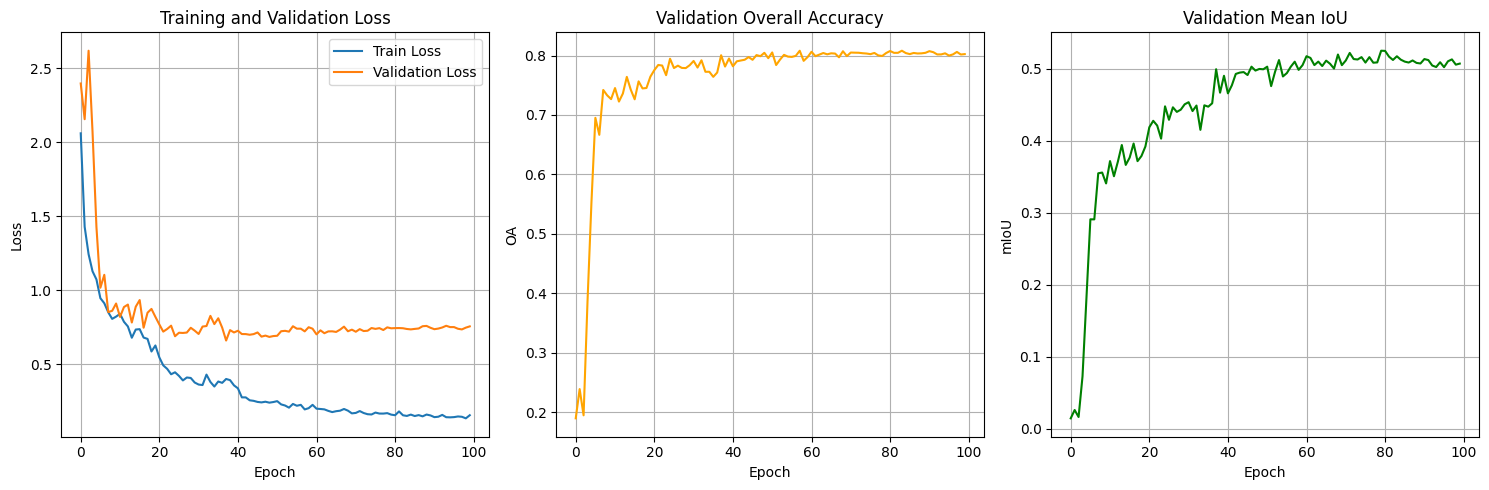


--- Final Results (Epoch 100) ---
Validation Loss: 0.7561
Overall Accuracy (OA): 0.8024
Mean IoU (mIoU): 0.5069


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_oas, label='Validation OA', color='orange')
plt.title('Validation Overall Accuracy')
plt.xlabel('Epoch')
plt.ylabel('OA')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_mious, label='Validation mIoU', color='green')
plt.title('Validation Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.grid(True)

plt.tight_layout()
plt.show()

final_val_loss = val_losses[-1]
final_val_oa = val_oas[-1]
final_val_miou = val_mious[-1]

print("\n--- Final Results (Epoch 100) ---")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Overall Accuracy (OA): {final_val_oa:.4f}")
print(f"Mean IoU (mIoU): {final_val_miou:.4f}")

## 13: Анализ

In [ ]:
print("--- Analysis of Training Curves ---")

if len(train_losses) > 1 and len(val_losses) > 1:
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    
    if final_val_loss > final_train_loss * 1.5:
        print("Analysis: Potential overfitting detected. Validation loss is significantly higher than training loss.")
        print("Reason: The model might be memorizing training data patterns that do not generalize well to validation data.")
    else:
        print("Analysis: No significant overfitting detected based on final loss values.")
        print("The gap between training and validation loss is relatively small.")


    if NUM_EPOCHS >= 10:
        recent_train_loss_avg = np.mean(train_losses[-5:])
        recent_val_loss_avg = np.mean(val_losses[-5:])
        early_train_loss_avg = np.mean(train_losses[:5])
        early_val_loss_avg = np.mean(val_losses[:5])
        
        print(f"Average Loss (First 5 epochs) - Train: {early_train_loss_avg:.4f}, Val: {early_val_loss_avg:.4f}")
        print(f"Average Loss (Last 5 epochs) - Train: {recent_train_loss_avg:.4f}, Val: {recent_val_loss_avg:.4f}")
        
        if abs(recent_train_loss_avg - early_train_loss_avg) < 0.01 and abs(recent_val_loss_avg - early_val_loss_avg) < 0.01:
             print("Analysis: The model might have reached a plateau in terms of loss reduction.")
        else:
             print("Analysis: Loss values continued to change significantly towards the end of training.")
else:
    print("Analysis: Training/Validation loss data not available for analysis.")

print("\n--- Analysis of Final Metrics (OA, mIoU) ---")

if val_oas and val_mious:
    final_oa = val_oas[-1]
    final_miou = val_mious[-1]
    print(f"Final Validation Overall Accuracy (OA): {final_oa:.4f}")
    print(f"Final Validation Mean IoU (mIoU): {final_miou:.4f}")
    
    print(f"Interpretation: OA of {final_oa:.2f} indicates the overall correctness. A high mIoU of {final_miou:.2f} suggests good performance across different classes, considering their individual boundaries.")
else:
    print("Analysis: Final OA/mIoU data not available for analysis.")

print("\nAnalysis of Per-Class IoU")

final_iou_per_class = None
if 'test_iou_per_class' in locals():
    final_iou_per_class = test_iou_per_class
    print("Using per-class IoU calculated on the Test set.")
elif val_mious:
    print("Calculating per-class IoU on the Validation set for analysis...")
    model.eval()
    all_preds_val_final = []
    all_labels_val_final = []

    with torch.no_grad():

        loader_to_analyze = val_loader_no_aug
        if loader_to_analyze is None:
            loader_to_analyze = val_loader_area2
        if loader_to_analyze is None:
            print("Error: No validation loader available for per-class IoU analysis.")
        else:
            for points, labels in tqdm(loader_to_analyze, desc="Calculating per-class IoU"):
                points = points.to(device) # (B, N, 6)
                labels = labels.to(device).view(-1) # (B*N,)

                outputs = model(points) # (B, N, num_classes) или model_part3(...)
                outputs = outputs.reshape(-1, NUM_CLASSES) # (B*N, num_classes)

                all_preds_val_final.append(outputs.cpu())
                all_labels_val_final.append(labels.cpu())

    if all_labels_val_final:
        all_preds_tensor_final = torch.cat(all_preds_val_final, dim=0) # (Total_B*N, num_classes)
        all_labels_tensor_final = torch.cat(all_labels_val_final, dim=0) # (Total_B*N,)

        _, _, final_iou_per_class = compute_metrics(all_preds_tensor_final, all_labels_tensor_final)

if final_iou_per_class is not None:
    print(f"Per-class IoU values:")
    for i, (class_name, iou) in enumerate(zip(CLASS_LABELS, final_iou_per_class)):
        print(f"  {class_name} (Class {i}): {iou:.4f}")

    print("\nAnalysis of per-class IoU:")
    best_classes_idx = np.argsort(final_iou_per_class)[::-1][:3]
    worst_classes_idx = np.argsort(final_iou_per_class)[:3]

    print(f"  Best segmented classes (Top 3 IoU):")
    for idx in best_classes_idx:
        print(f"    - {CLASS_LABELS[idx]} (Class {idx}): IoU = {final_iou_per_class[idx]:.4f}")
    print(f"    Reason (likely): These classes often have distinct geometric structures (e.g., flat surfaces like 'floor', 'ceiling') or large, consistent spatial extent, making them easier for the model to identify.")

    print(f"  Worst segmented classes (Bottom 3 IoU):")
    for idx in worst_classes_idx:
        print(f"    - {CLASS_LABELS[idx]} (Class {idx}): IoU = {final_iou_per_class[idx]:.4f}")
    print(f"    Reason (likely): These classes might be underrepresented in the training data, have ambiguous boundaries (e.g., 'clutter' is often small, scattered objects), or share geometric features with other classes (e.g., 'board' might be on a 'wall'). Smaller objects ('chair', 'table') can also be harder to segment accurately if the receptive field or sampling density is not optimal.")
else:
    print("Error: missing data.")

print("\n--- Suggested Improvements ---")
print("Potential ways to improve the model's performance are:")
print("  - Class Balancing: Implement weighted Cross-Entropy Loss. S3DIS has a significant class imbalance (e.g., 'floor', 'wall' dominate). Calculating class weights inversely proportional to their frequency and passing them to nn.CrossEntropyLoss can help the model pay more attention to underrepresented classes like 'chair', 'sofa', 'board', potentially improving their IoU and the overall mIoU.")
print("  - Data Augmentation: Increase the diversity of training data using more sophisticated augmentations (e.g., rotation around Z-axis, scaling) or Synthetic Data Generation techniques if applicable.")

--- Analysis of Training Curves ---
Final Training Loss: 0.1562
Final Validation Loss: 0.7561
Analysis: Potential overfitting detected. Validation loss is significantly higher than training loss.
Reason: The model might be memorizing training data patterns that do not generalize well to validation data.
Average Loss (First 5 epochs) - Train: 1.3865, Val: 2.1334
Average Loss (Last 5 epochs) - Train: 0.1457, Val: 0.7461
Analysis: Loss values continued to change significantly towards the end of training.

--- Analysis of Final Metrics (OA, mIoU) ---
Final Validation Overall Accuracy (OA): 0.8024
Final Validation Mean IoU (mIoU): 0.5069
Interpretation: OA of 0.80 indicates the overall correctness. A high mIoU of 0.51 suggests good performance across different classes, considering their individual boundaries.

--- Analysis of Per-Class IoU ---
Calculating per-class IoU on the Validation set for analysis...


Calculating per-class IoU:   0%|          | 0/13 [00:00<?, ?it/s]

Calculating per-class IoU: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]

Per-class IoU values:
  ceiling (Class 0): 0.8868
  floor (Class 1): 0.8579
  wall (Class 2): 0.6516
  beam (Class 3): 0.5615
  column (Class 4): 0.2062
  window (Class 5): 0.7285
  door (Class 6): 0.5135
  table (Class 7): 0.5562
  chair (Class 8): 0.3565
  sofa (Class 9): 0.0950
  bookcase (Class 10): 0.4307
  board (Class 11): 0.2666
  clutter (Class 12): 0.4188

Analysis of per-class IoU:
  Best segmented classes (Top 3 IoU):
    - ceiling (Class 0): IoU = 0.8868
    - floor (Class 1): IoU = 0.8579
    - window (Class 5): IoU = 0.7285
    Reason (likely): These classes often have distinct geometric structures (e.g., flat surfaces like 'floor', 'ceiling') or large, consistent spatial extent, making them easier for the model to identify.
  Worst segmented classes (Bottom 3 IoU):
    - sofa (Class 9): IoU = 0.0950
    - column (Class 4): IoU = 0.2062
    - board (Class 11): IoU = 0.2666
    Reason (likely): These classes might be underrepresented in the training data, have ambiguous b

## 14: Визуализация

In [ ]:
def visualize_block_open3d(points_xyz_rgb, true_labels=None, pred_labels=None, title="Point Cloud"):
    """
    Args:
        points_xyz_rgb (np.ndarray): Точки формы (N, 6) -> [x, y, z, r, g, b].
        true_labels (np.ndarray, optional): Истинные метки формы (N,), значения от 0 до NUM_CLASSES-1.
        pred_labels (np.ndarray, optional): Предсказанные метки формы (N,), значения от 0 до NUM_CLASSES-1.
    """
    coords = points_xyz_rgb[:, :3] # (N, 3)
    
    if points_xyz_rgb[:, 3:].max() > 1:
        colors_rgb = points_xyz_rgb[:, 3:] / 255.0
    else:
        colors_rgb = points_xyz_rgb[:, 3:]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(coords)

    if pred_labels is not None:
        vis_colors = COLOR_PALETTE[pred_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(vis_colors)
        current_title = f"{title} - Predicted Labels"
    elif true_labels is not None:
        vis_colors = COLOR_PALETTE[true_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(vis_colors)
        current_title = f"{title} - True Labels"
    else:
        pcd.colors = o3d.utility.Vector3dVector(colors_rgb)
        current_title = f"{title} - Original RGB"

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=current_title, width=800, height=600)
    vis.add_geometry(pcd)
    
    vis.run()
    vis.destroy_window()

print("Visualization function 'visualize_block_open3d' defined.")

Visualization function 'visualize_block_open3d' defined.


Starting visualization of blocks from the validation dataset using Matplotlib...
Processing block 1...
  Predictions computed for block 1.


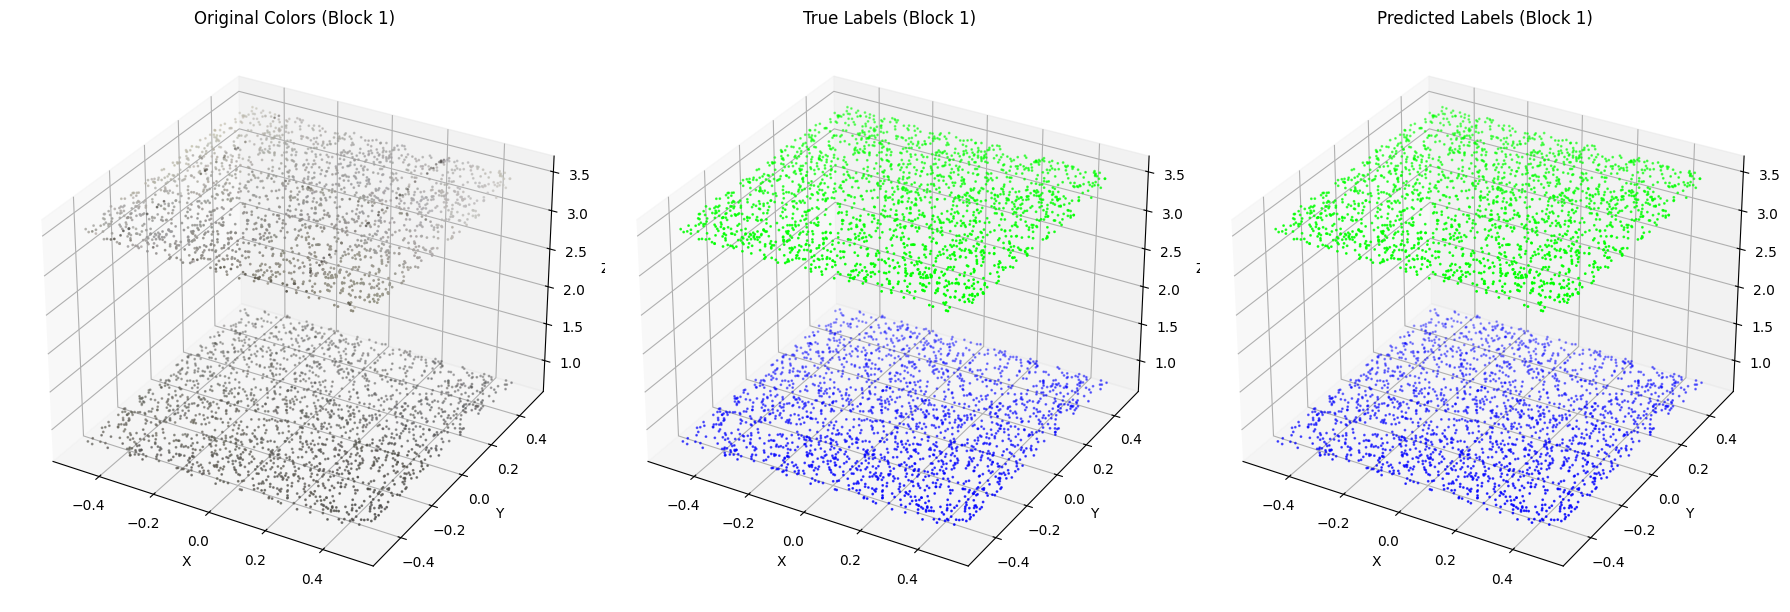

  Successfully visualized block 1 with Matplotlib.
Processing block 2...
  Predictions computed for block 2.


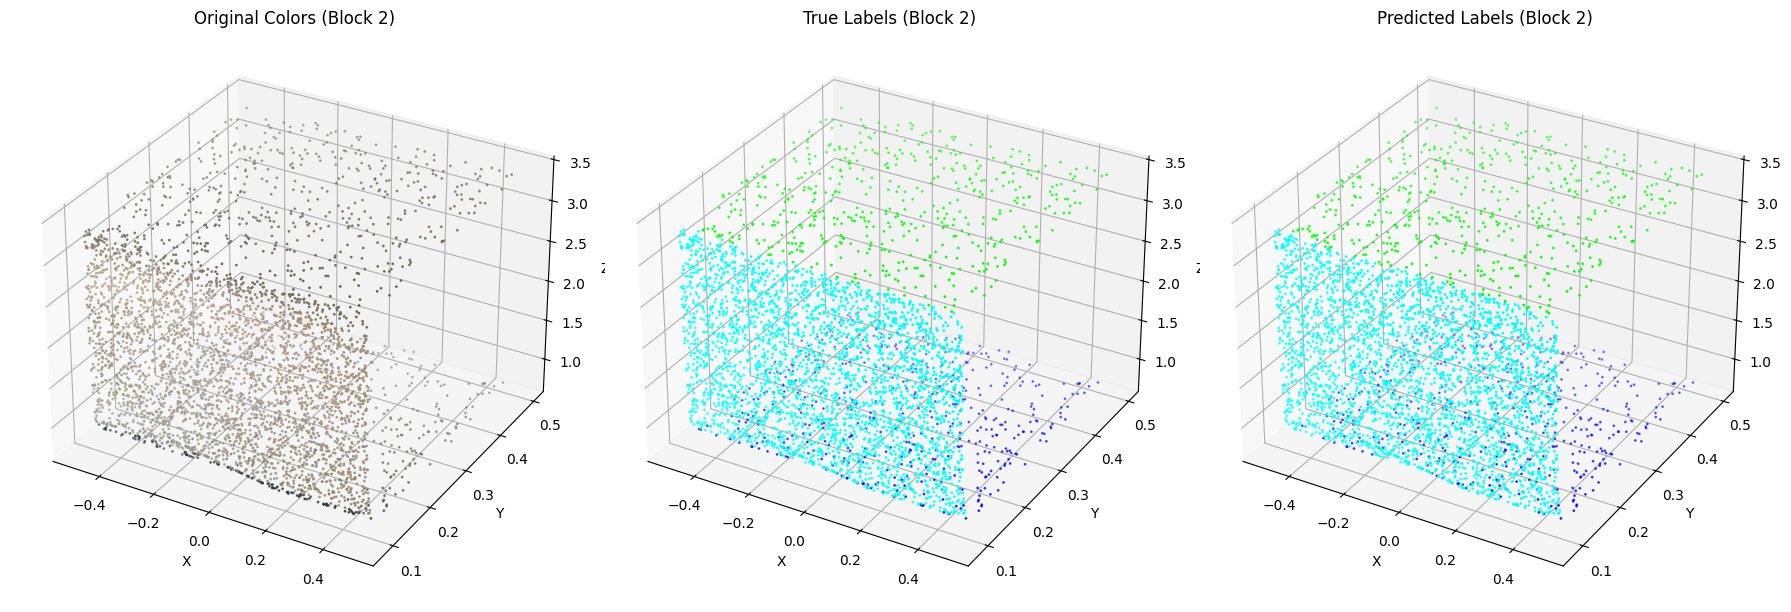

  Successfully visualized block 2 with Matplotlib.
Processing block 3...
  Predictions computed for block 3.


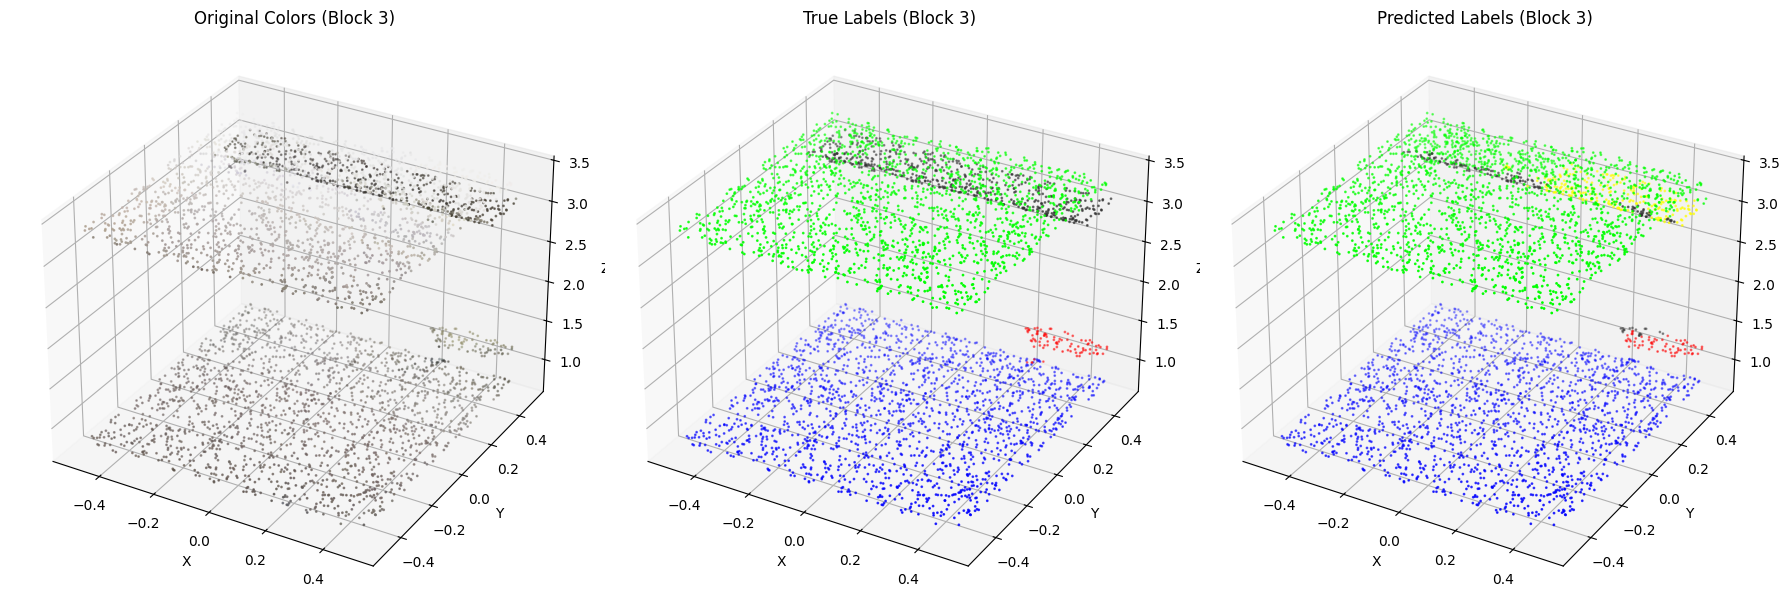

  Successfully visualized block 3 with Matplotlib.
Completed visualization attempt for 3 blocks using Matplotlib.


In [ ]:
if 'model' in locals() and 'val_dataset_no_aug' in locals() and val_dataset_no_aug is not None:
    print("Starting visualization of blocks from the validation dataset using Matplotlib...")
    model.eval()

    num_blocks_to_visualize = min(3, len(val_dataset_no_aug))
    blocks_visualized = 0

    for i in range(num_blocks_to_visualize):
        try:
            print(f"Processing block {i+1}...")
            points_np, labels_np = val_dataset_no_aug[i]
            if torch.is_tensor(points_np):
                points_np = points_np.numpy()
            if torch.is_tensor(labels_np):
                labels_np = labels_np.numpy()

            points_tensor = torch.from_numpy(points_np).unsqueeze(0).to(device)
            outputs = model(points_tensor)
            outputs = outputs.squeeze(0)
            preds_np = torch.argmax(outputs, dim=1).cpu().numpy()

            print(f"  Predictions computed for block {i+1}.")

            if points_np[:, 3:].max() > 1:
                colors_original = points_np[:, 3:] / 255.0
            else:
                colors_original = points_np[:, 3:]

            true_colors = COLOR_PALETTE[labels_np] / 255.0

            pred_colors = COLOR_PALETTE[preds_np] / 255.0

            fig = plt.figure(figsize=(18, 6))

            ax1 = fig.add_subplot(131, projection='3d')
            ax1.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], c=colors_original, s=1)
            ax1.set_title(f"Original Colors (Block {i+1})")
            ax1.set_xlabel("X")
            ax1.set_ylabel("Y")
            ax1.set_zlabel("Z")

            ax2 = fig.add_subplot(132, projection='3d')
            ax2.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], c=true_colors, s=1)
            ax2.set_title(f"True Labels (Block {i+1})")
            ax2.set_xlabel("X")
            ax2.set_ylabel("Y")
            ax2.set_zlabel("Z")

            ax3 = fig.add_subplot(133, projection='3d')
            ax3.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], c=pred_colors, s=1)
            ax3.set_title(f"Predicted Labels (Block {i+1})")
            ax3.set_xlabel("X")
            ax3.set_ylabel("Y")
            ax3.set_zlabel("Z")

            plt.tight_layout()
            plt.show()

            blocks_visualized += 1
            print(f"  Successfully visualized block {blocks_visualized} with Matplotlib.")

        except Exception as e:
            print(f"  Error visualizing block {i+1} with Matplotlib: {e}")
            import traceback
            traceback.print_exc()
            continue

    print(f"Completed visualization attempt for {blocks_visualized} blocks using Matplotlib.")
else:
    print("Trained model ('model') or validation dataset ('val_dataset_no_aug') not available or empty. Cannot perform visualization with Matplotlib.")

## **Контрольные вопросы:**
1. Оригинальный PointNet обрабатывает все точки облака глобально за один проход, используя операции, инвариантные к перестановке (например, max pooling). Это позволяет ему извлекать глобальные признаки объекта, но он не учитывает локальные структуры и геометрические отношения между близкими точками. PointNet++ преодолевает это ограничение, вводя иерархическую структуру: он разбивает облако точек на локальные регионы (с помощью выборки по дальним точкам и группировки по шарам), применяет PointNet-подобные слои к этим локальным регионам, чтобы извлекать локальные признаки, а затем объединяет их на более высоких уровнях. Это позволяет PointNet++ лучше улавливать детали и локальные геометрические особенности, что критично для задачи сегментации.
2. Основные проблемы при работе с реальными данными:

    Неравномерная плотность точек: Лазерные сканеры могут по-разному "видеть" разные участки сцены, приводя к неравномерному распределению точек. Объекты, находящиеся дальше от сканера, будут представлены с меньшей плотностью.

    Шум и артефакты: Реальные сканы содержат шум, выбросы и артефакты, возникающие из-за отражений, прозрачности, пыли или проблем с самим оборудованием. 

    Классовый дисбаланс: В S3DIS, как и в большинстве реальных сцен, некоторые классы (например, "пол", "стена") представлены намного чаще, чем другие ("доска", "диван"). Это может привести к смещению модели в сторону более распространённых классов и нерепрезентативной выборке.

    Сложная геометрия и перекрытия: Объекты могут иметь сложные формы, быть частично скрытыми или перекрываться, что затрудняет точную сегментацию.

    Неоднозначность разметки: Границы между объектами могут быть размыты, и разметка может варьироваться в зависимости от интерпретации. Например, доска на стене может быть размечена как "доска" или "стена", в зависимости от контекста.

    Недостаток данных: Некоторые редкие объекты ("clutter", специфическая мебель) могут быть представлены в датасете в очень малом количестве, что затрудняет обучение модели их распознаванию.

3.  Overall Accuracy (OA) – доля правильно классифицированных точек от общего числа. Она может быть обманчиво высокой, если модель хорошо сегментирует большие, доминирующие классы ("пол", "стена"), но плохо – маленькие или редкие ("доска", "диван"). OA не учитывает, насколько хорошо модель сегментирует каждый класс отдельно.

    Mean Intersection over Union (mIoU) – это среднее значение IoU по всем классам. IoU для каждого класса вычисляется как TP / (TP + FP + FN), где TP – это правильно предсказанные точки класса, FP – точки, предсказанные как класс, но принадлежащие другому, FN – точки класса, предсказанные как другой. mIoU учитывает как точность, так и полноту для каждого класса, а затем усредняет. Это делает mIoU гораздо более чувствительной к качеству сегментации всех классов, а не только самых распространённых. Модель с высоким mIoU показывает хорошую сегментацию для всех 13 классов S3DIS, а не только для распространенных вроде "пола" или "стены".

